# Evaluación de Modelos LLM en Modismos Colombianos

Este notebook evalúa qué tan bien los modelos LLM entienden los modismos colombianos usando:
- **BERTScore**: Para comparar similitud semántica entre textos (definiciones)
- **AlignScore**: Para evaluar consistencia entre contexto y afirmaciones
- **Accuracy/Exact Match**: Para clasificación y coincidencias exactas

In [10]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configuracion
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', 100)

# Estilos para graficos
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)

# Modelos
MODEL_NAMES = ["Amazon_Nova_Micro_V1", "Cohere_Command_R_08_2024"]

# Directorios
DATA_DIR = 'Data_for_Metrics'
OUTPUT_DIR = 'Metricas_Resultados'
os.makedirs(OUTPUT_DIR, exist_ok=True)

print(f"Datos en: {DATA_DIR}")
print(f"Resultados en: {OUTPUT_DIR}")

Datos en: Data_for_Metrics
Resultados en: Metricas_Resultados


## 1. Cargar Funciones de Métricas

In [11]:
# Importar funciones de BERTScore y AlignScore
from BertScore_Beto import compute_bertscore
from AlingScore import scorer

print("BERTScore y AlignScore cargados correctamente")

BERTScore y AlignScore cargados correctamente


## 2. PROMPT 1: Modismo → Definición
**Métrica**: BERTScore (F1)  
**Justificación**: Evalúa similitud semántica entre la definición generada y la real. Ideal para entender si el modelo captura el significado del modismo.

In [12]:
print("Prompt 1: Modismo → Definición (BERTScore)")

df_p1 = pd.read_csv(os.path.join(DATA_DIR, 'prompt_1_metrics_data.csv'))
df_p1 = df_p1.dropna(subset=['definicion_real', MODEL_NAMES[0], MODEL_NAMES[1]])

resultados_p1 = []

for model in MODEL_NAMES:
    referencias = df_p1['definicion_real'].tolist()
    candidatos = df_p1[model].tolist()
    
    P, R, F1 = compute_bertscore(candidatos, referencias)
    
    for idx, (p, r, f1) in enumerate(zip(P.tolist(), R.tolist(), F1.tolist())):
        resultados_p1.append({
            'modismo': df_p1.iloc[idx]['modismo'],
            'modelo': model,
            'precision': p,
            'recall': r,
            'f1_score': f1,
            'definicion_real': referencias[idx],
            'definicion_generada': candidatos[idx]
        })

df_resultados_p1 = pd.DataFrame(resultados_p1)
output_file = os.path.join(OUTPUT_DIR, 'prompt_1_bertscore_resultados.csv')
df_resultados_p1.to_csv(output_file, index=False)

for model in MODEL_NAMES:
    f1_mean = df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean()
    print(f"  {model}: F1 = {f1_mean:.4f}")

Prompt 1: Modismo → Definición (BERTScore)
  Amazon_Nova_Micro_V1: F1 = 0.4888
  Cohere_Command_R_08_2024: F1 = 0.4958


## 3. PROMPT 2: Modismo → Es Modismo (Sí/No)
**Métrica**: Accuracy  
**Justificación**: Es una tarea de clasificación binaria. Mide si el modelo identifica correctamente que una expresión es un modismo.

In [13]:
print("Prompt 2: Es Modismo (Accuracy)")

df_p2 = pd.read_csv(os.path.join(DATA_DIR, 'prompt_2_metrics_data.csv'))
df_p2 = df_p2.dropna(subset=['es_modismo_real', MODEL_NAMES[0], MODEL_NAMES[1]])

def normalizar_respuesta(respuesta):
    if pd.isna(respuesta):
        return None
    respuesta = str(respuesta).strip().lower()
    if respuesta in ['sí', 'si', 'yes', 's']:
        return 'Sí'
    elif respuesta in ['no', 'n']:
        return 'No'
    return respuesta

df_p2['es_modismo_real'] = df_p2['es_modismo_real'].apply(normalizar_respuesta)

resultados_p2 = []

for model in MODEL_NAMES:
    df_p2[f'{model}_normalizado'] = df_p2[model].apply(normalizar_respuesta)
    
    correctos = (df_p2['es_modismo_real'] == df_p2[f'{model}_normalizado']).sum()
    total = len(df_p2)
    accuracy = correctos / total if total > 0 else 0
    
    for idx, row in df_p2.iterrows():
        resultados_p2.append({
            'modismo': row['modismo'],
            'modelo': model,
            'respuesta_real': row['es_modismo_real'],
            'respuesta_generada': row[f'{model}_normalizado'],
            'correcto': row['es_modismo_real'] == row[f'{model}_normalizado']
        })
    
    print(f"  {model}: Accuracy = {accuracy:.4f}")

df_resultados_p2 = pd.DataFrame(resultados_p2)
output_file = os.path.join(OUTPUT_DIR, 'prompt_2_accuracy_resultados.csv')
df_resultados_p2.to_csv(output_file, index=False)

Prompt 2: Es Modismo (Accuracy)
  Amazon_Nova_Micro_V1: Accuracy = 0.1200
  Cohere_Command_R_08_2024: Accuracy = 0.6100


## 4. PROMPT 3: Definición → Modismo
**Métrica**: AlignScore  
**Justificación**: Evalúa si el modismo generado es consistente con la definición dada

In [14]:
print("Prompt 3: Definición → Modismo (AlignScore)")

df_p3 = pd.read_csv(os.path.join(DATA_DIR, 'prompt_3_metrics_data.csv'))
df_p3 = df_p3.dropna(subset=['definicion', 'modismo_real', MODEL_NAMES[0], MODEL_NAMES[1]])

resultados_p3 = []

for model in MODEL_NAMES:
    contexts = df_p3['definicion'].tolist()
    claims = df_p3[model].tolist()
    
    align_scores = scorer.score(contexts=contexts, claims=claims)
    
    for idx, align_score in enumerate(align_scores):
        resultados_p3.append({
            'definicion': contexts[idx],
            'modismo_real': df_p3.iloc[idx]['modismo_real'],
            'modelo': model,
            'modismo_generado': claims[idx],
            'align_score': align_score
        })

df_resultados_p3 = pd.DataFrame(resultados_p3)
output_file = os.path.join(OUTPUT_DIR, 'prompt_3_alignscore_resultados.csv')
df_resultados_p3.to_csv(output_file, index=False)

for model in MODEL_NAMES:
    align_mean = df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean()
    print(f"  {model}: AlignScore = {align_mean:.4f}")

Prompt 3: Definición → Modismo (AlignScore)


Evaluating: 100%|██████████| 99/99 [00:03<00:00, 26.87it/s]

  Amazon_Nova_Micro_V1: AlignScore = 0.2471
  Cohere_Command_R_08_2024: AlignScore = 0.2019


## 5. PROMPT 4a: Sinónimos en Contexto
**Métrica**: AlignScore  
**Justificación**: Evalúa si el sinónimo (literal) generado mantiene consistencia con el ejemplo original. Mide si el modelo entiende el significado contextual del modismo.

In [15]:
print("Prompt 4a: Sinónimos en Contexto (AlignScore)")

df_p4_sin = pd.read_csv(os.path.join(DATA_DIR, 'prompt_4_ejemplos_sustitucion.csv'))
df_p4_sin = df_p4_sin.dropna(subset=['ejemplo_real'])

resultados_p4a = []

for model in MODEL_NAMES:
    df_valido = df_p4_sin[df_p4_sin[f'{model}_ejemplo_con_sinonimo'].notna()].copy()
    
    if len(df_valido) == 0:
        continue
    
    contexts = df_valido['ejemplo_real'].tolist()
    claims = df_valido[f'{model}_ejemplo_con_sinonimo'].tolist()
    
    align_scores = scorer.score(contexts=contexts, claims=claims)
    
    for idx, align_score in enumerate(align_scores):
        resultados_p4a.append({
            'modismo': df_valido.iloc[idx]['modismo'],
            'ejemplo_original': contexts[idx],
            'modelo': model,
            'sinonimo': df_valido.iloc[idx][f'{model}_sinonimo'],
            'ejemplo_con_sinonimo': claims[idx],
            'align_score': align_score
        })

df_resultados_p4a = pd.DataFrame(resultados_p4a)
output_file = os.path.join(OUTPUT_DIR, 'prompt_4a_sinonimos_alignscore_resultados.csv')
df_resultados_p4a.to_csv(output_file, index=False)

for model in MODEL_NAMES:
    align_mean = df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].mean()
    print(f"  {model}: AlignScore = {align_mean:.4f}")

Prompt 4a: Sinónimos en Contexto (AlignScore)


Evaluating: 100%|██████████| 91/91 [00:03<00:00, 25.00it/s]

  Amazon_Nova_Micro_V1: AlignScore = 0.5785
  Cohere_Command_R_08_2024: AlignScore = 0.6040


## 6. PROMPT 4b: Definiciones de Sinónimos
**Métrica**: BERTScore (F1)  
**Justificación**: Compara la definición del sinónimo generada con la definición real del modismo. Evalúa si el modelo comprende que el sinónimo debe tener un significado similar.

In [16]:
print("Prompt 4b: Definiciones de Sinónimos (BERTScore)")

df_p4_def = pd.read_csv(os.path.join(DATA_DIR, 'prompt_4_definiciones.csv'))
df_p4_def = df_p4_def.dropna(subset=['definicion_real'])

resultados_p4b = []

for model in MODEL_NAMES:
    df_valido = df_p4_def[df_p4_def[f'{model}_definicion_sinonimo'].notna()].copy()
    
    if len(df_valido) == 0:
        continue
    
    referencias = df_valido['definicion_real'].tolist()
    candidatos = df_valido[f'{model}_definicion_sinonimo'].tolist()
    
    P, R, F1 = compute_bertscore(candidatos, referencias)
    
    for idx, (p, r, f1) in enumerate(zip(P.tolist(), R.tolist(), F1.tolist())):
        resultados_p4b.append({
            'modismo': df_valido.iloc[idx]['modismo'],
            'modelo': model,
            'precision': p,
            'recall': r,
            'f1_score': f1,
            'definicion_real': referencias[idx],
            'definicion_sinonimo': candidatos[idx]
        })

df_resultados_p4b = pd.DataFrame(resultados_p4b)
output_file = os.path.join(OUTPUT_DIR, 'prompt_4b_definiciones_bertscore_resultados.csv')
df_resultados_p4b.to_csv(output_file, index=False)

for model in MODEL_NAMES:
    f1_mean = df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].mean()
    print(f"  {model}: F1 = {f1_mean:.4f}")

Prompt 4b: Definiciones de Sinónimos (BERTScore)
  Amazon_Nova_Micro_V1: F1 = 0.5294
  Cohere_Command_R_08_2024: F1 = 0.5372


## 7. Visualizaciones: Diagramas de Cajas y Bigotes

Comparación visual de las métricas por modelo para cada prompt

Generando visualizaciones...
Guardado: Metricas_Resultados/comparacion_modelos_boxplots.png


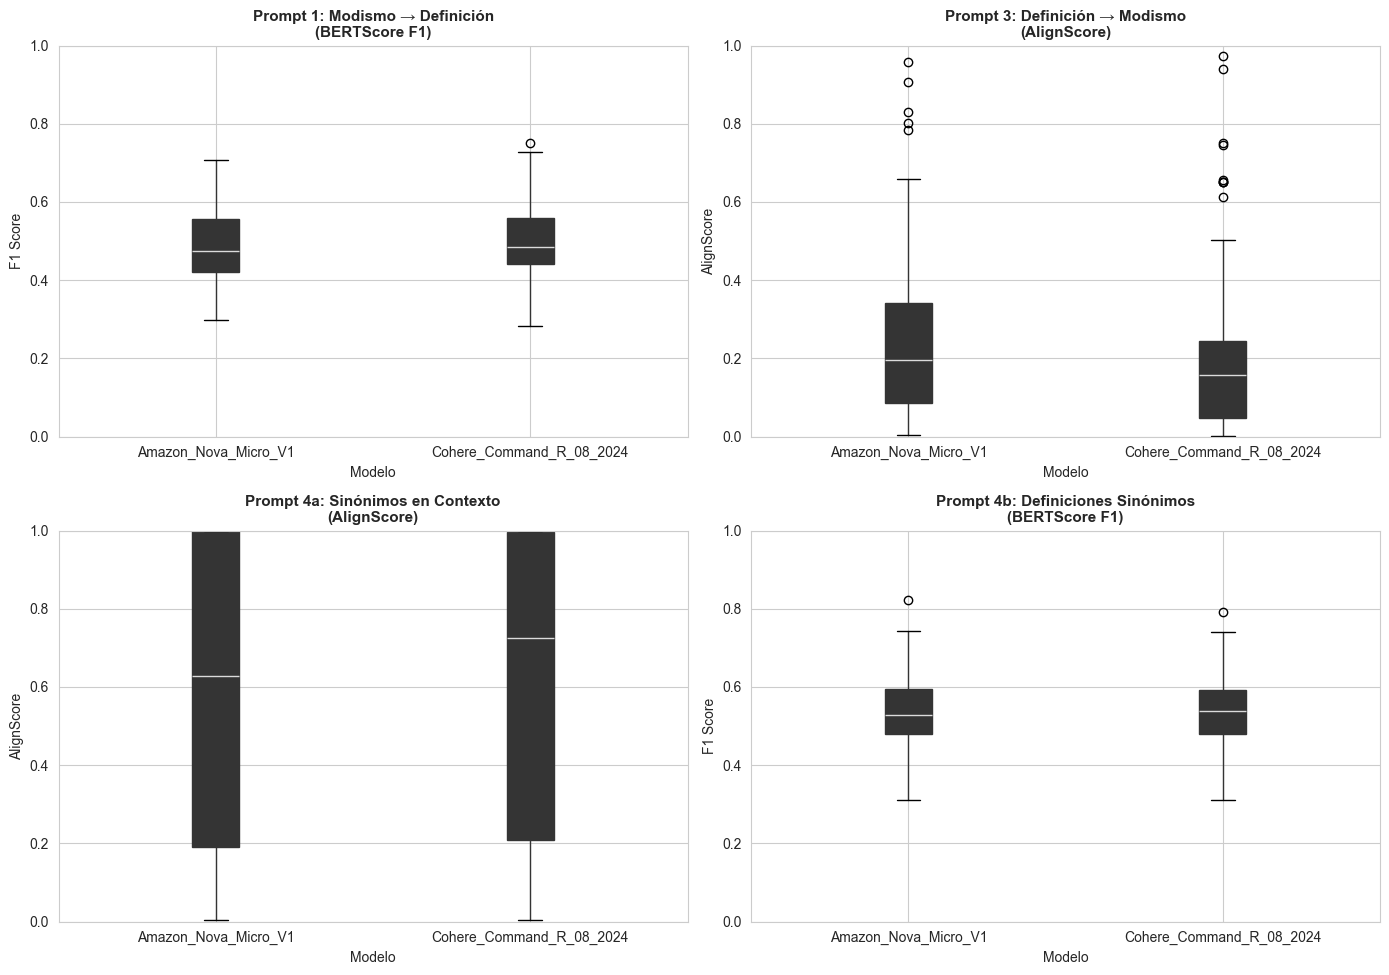

In [17]:
print("Generando visualizaciones...")

colors = ['#3498db', '#e74c3c']
sns.set_palette(colors)

fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Comparación de Modelos en Comprensión de Modismos Colombianos', 
             fontsize=16, fontweight='bold', y=0.995)

# 1. Prompt 1: BERTScore F1
ax1 = axes[0, 0]
df_resultados_p1.boxplot(column='f1_score', by='modelo', ax=ax1, patch_artist=True)
ax1.set_title('Prompt 1: Modismo → Definición\n(BERTScore F1)', fontsize=11, fontweight='bold')
ax1.set_xlabel('Modelo', fontsize=10)
ax1.set_ylabel('F1 Score', fontsize=10)
ax1.set_ylim([0, 1])
ax1.get_figure().suptitle('')

# 2. Prompt 3: AlignScore
ax2 = axes[0, 1]
df_resultados_p3.boxplot(column='align_score', by='modelo', ax=ax2, patch_artist=True)
ax2.set_title('Prompt 3: Definición → Modismo\n(AlignScore)', fontsize=11, fontweight='bold')
ax2.set_xlabel('Modelo', fontsize=10)
ax2.set_ylabel('AlignScore', fontsize=10)
ax2.set_ylim([0, 1])
ax2.get_figure().suptitle('')

# 3. Prompt 4a: AlignScore Sinónimos
ax3 = axes[1, 0]
if len(df_resultados_p4a) > 0:
    df_resultados_p4a.boxplot(column='align_score', by='modelo', ax=ax3, patch_artist=True)
    ax3.set_title('Prompt 4a: Sinónimos en Contexto\n(AlignScore)', fontsize=11, fontweight='bold')
    ax3.set_xlabel('Modelo', fontsize=10)
    ax3.set_ylabel('AlignScore', fontsize=10)
    ax3.set_ylim([0, 1])
    ax3.get_figure().suptitle('')
else:
    ax3.text(0.5, 0.5, 'Sin datos', ha='center', va='center', transform=ax3.transAxes)
    ax3.set_title('Prompt 4a: Sinónimos', fontsize=11)

# 4. Prompt 4b: BERTScore Definiciones
ax4 = axes[1, 1]
if len(df_resultados_p4b) > 0:
    df_resultados_p4b.boxplot(column='f1_score', by='modelo', ax=ax4, patch_artist=True)
    ax4.set_title('Prompt 4b: Definiciones Sinónimos\n(BERTScore F1)', fontsize=11, fontweight='bold')
    ax4.set_xlabel('Modelo', fontsize=10)
    ax4.set_ylabel('F1 Score', fontsize=10)
    ax4.set_ylim([0, 1])
    ax4.get_figure().suptitle('')
else:
    ax4.text(0.5, 0.5, 'Sin datos', ha='center', va='center', transform=ax4.transAxes)
    ax4.set_title('Prompt 4b: Definiciones', fontsize=11)

plt.tight_layout()

output_fig = os.path.join(OUTPUT_DIR, 'comparacion_modelos_boxplots.png')
plt.savefig(output_fig, dpi=300, bbox_inches='tight')
print(f"Guardado: {output_fig}")

plt.show()

## 8. Tabla Consolidada de Resultados

In [18]:
print("Tabla Consolidada de Resultados")
print("=" * 80)

resultados = []

for model in MODEL_NAMES:
    p1_f1 = df_resultados_p1[df_resultados_p1['modelo'] == model]['f1_score'].mean()
    p2_acc = df_resultados_p2[df_resultados_p2['modelo'] == model]['correcto'].mean()
    p3_align = df_resultados_p3[df_resultados_p3['modelo'] == model]['align_score'].mean()
    p4a_align = df_resultados_p4a[df_resultados_p4a['modelo'] == model]['align_score'].mean() if len(df_resultados_p4a) > 0 else 0
    p4b_f1 = df_resultados_p4b[df_resultados_p4b['modelo'] == model]['f1_score'].mean() if len(df_resultados_p4b) > 0 else 0
    
    resultados.append({
        'Modelo': model,
        'P1_BERTScore_F1': f"{p1_f1:.4f}",
        'P2_Accuracy': f"{p2_acc:.4f}",
        'P3_AlignScore': f"{p3_align:.4f}",
        'P4a_AlignScore': f"{p4a_align:.4f}",
        'P4b_BERTScore_F1': f"{p4b_f1:.4f}"
    })

df_tabla = pd.DataFrame(resultados)
print(df_tabla.to_string(index=False))
print("=" * 80)

output_file = os.path.join(OUTPUT_DIR, 'resultados_consolidados.csv')
df_tabla.to_csv(output_file, index=False)
print(f"Guardado: {output_file}")

Tabla Consolidada de Resultados
                  Modelo P1_BERTScore_F1 P2_Accuracy P3_AlignScore P4a_AlignScore P4b_BERTScore_F1
    Amazon_Nova_Micro_V1          0.4888      0.1200        0.2471         0.5785           0.5294
Cohere_Command_R_08_2024          0.4958      0.6100        0.2019         0.6040           0.5372
Guardado: Metricas_Resultados/resultados_consolidados.csv
